# Oil and Gas Production Forecasting - LSTM Model

### How LSTM Works:

1. **Modeling Sequential Data:**  
LSTMs process data sequentially, one time point at a time (such as daily temperature readings), learning temporal patterns like overall trends and repeating seasonal effects.

2. **Memory Cells and Gates:**  
LSTM networks contain specialized memory cells regulated by three types of gates:  
- **Input Gate:** Controls what new information is added to the memory.  
- **Forget Gate:** Determines which information is discarded from memory.  
- **Output Gate:** Decides what information is sent forward as output from the cell.

3. **Capturing Long-Term Dependencies:**  
Unlike traditional RNNs, LSTMs efficiently learn long-range dependencies in the data, such as how a marketing campaign from several months ago might impact current sales figures.

### 1-Imports and dataset loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import optuna
import json
import os

sns.set(style="whitegrid")

In [3]:
# Load dataset
df = pd.read_csv("../data/processed/oil_production_features.csv")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

### 2-Feature + target selection

In [5]:
features = df.drop(['period', 'target'], axis=1).columns.tolist()

X = df[features].values
y = df['target'].values

### 3-Train-test split

In [6]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### 4-Scaling

In [7]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

### 5-Reshape for LSTM input

In [ ]:
# LSTM expects (samples, timesteps, features)
# We use 1 timestep (current + lagged + rolling context)

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

### 6-Hyperparameter tuning using Oputna

In [9]:
def objective(trial):
    model = Sequential()
    model.add(LSTM(
        units=trial.suggest_int('units', 32, 128),
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
        return_sequences=False
    ))
    model.add(Dropout(trial.suggest_float('dropout', 0.1, 0.5)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(
        X_train_scaled, y_train_scaled,
        epochs=trial.suggest_int('epochs', 10, 50),
        batch_size=trial.suggest_int('batch_size', 16, 64),
        verbose=0,
        callbacks=[EarlyStopping(monitor='loss', patience=5)]
    )
    
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-09-17 16:26:15,935] A new study created in memory with name: no-name-7b556c48-6fc8-47a0-9bc2-4225ac97ba7c
E0000 00:00:1758106577.663318 1453368 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758106577.668400 1453368 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model i

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


[I 2025-09-17 16:26:25,423] Trial 0 finished with value: 90.95234258742559 and parameters: {'units': 43, 'dropout': 0.47738075323556994, 'epochs': 45, 'batch_size': 24}. Best is trial 0 with value: 90.95234258742559.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-09-17 16:26:32,750] Trial 1 finished with value: 88.3809070405506 and parameters: {'units': 104, 'dropout': 0.3990346673024301, 'epochs': 44, 'batch_size': 47}. Best is trial 1 with value: 88.3809070405506.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f838454a200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


[I 2025-09-17 16:26:38,855] Trial 2 finished with value: 96.45299711681548 and parameters: {'units': 76, 'dropout': 0.4792338626667142, 'epochs': 14, 'batch_size': 37}. Best is trial 1 with value: 88.3809070405506.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-09-17 16:26:45,014] Trial 3 finished with value: 100.5365466889881 and parameters: {'units': 115, 'dropout': 0.22155741301561616, 'epochs': 40, 'batch_size': 16}. Best is trial 1 with value: 88.3809070405506.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-09-17 16:26:51,669] Trial 4 finished with value: 80.06441010974703 and parameters: {'units': 32, 'dropout': 0.10382692185818475, 'epochs': 49, 'batch_size': 46}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-09-17 16:27:00,639] Trial 5 finished with value: 95.06245465959822 and parameters: {'units': 125, 'dropout': 0.3880863218692364, 'epochs': 24, 'batch_size': 31}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


[I 2025-09-17 16:27:06,042] Trial 6 finished with value: 110.1870372953869 and parameters: {'units': 108, 'dropout': 0.4712726709479895, 'epochs': 12, 'batch_size': 58}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


[I 2025-09-17 16:27:13,567] Trial 7 finished with value: 99.18426571800595 and parameters: {'units': 119, 'dropout': 0.4332896483070453, 'epochs': 34, 'batch_size': 57}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


[I 2025-09-17 16:27:21,998] Trial 8 finished with value: 96.49826427641369 and parameters: {'units': 107, 'dropout': 0.2566896685053669, 'epochs': 33, 'batch_size': 56}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-09-17 16:27:27,520] Trial 9 finished with value: 93.72002418154761 and parameters: {'units': 116, 'dropout': 0.3465433964930321, 'epochs': 32, 'batch_size': 49}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-09-17 16:27:32,902] Trial 10 finished with value: 105.08924734933036 and parameters: {'units': 34, 'dropout': 0.11874048906995452, 'epochs': 49, 'batch_size': 43}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-09-17 16:27:40,481] Trial 11 finished with value: 91.54828869047618 and parameters: {'units': 84, 'dropout': 0.10086235289963044, 'epochs': 50, 'batch_size': 48}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


[I 2025-09-17 16:27:46,711] Trial 12 finished with value: 106.67110305059524 and parameters: {'units': 61, 'dropout': 0.19057108237976772, 'epochs': 41, 'batch_size': 64}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[I 2025-09-17 16:27:53,982] Trial 13 finished with value: 83.68013625372024 and parameters: {'units': 91, 'dropout': 0.3180692060474192, 'epochs': 40, 'batch_size': 38}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-09-17 16:27:59,705] Trial 14 finished with value: 102.16972074962797 and parameters: {'units': 86, 'dropout': 0.30083341828131716, 'epochs': 23, 'batch_size': 34}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


[I 2025-09-17 16:28:05,417] Trial 15 finished with value: 85.50707775297619 and parameters: {'units': 61, 'dropout': 0.32829490884396567, 'epochs': 38, 'batch_size': 28}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


[I 2025-09-17 16:28:12,421] Trial 16 finished with value: 89.78240327380952 and parameters: {'units': 96, 'dropout': 0.1673345919723747, 'epochs': 46, 'batch_size': 41}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


[I 2025-09-17 16:28:18,644] Trial 17 finished with value: 102.65319475446428 and parameters: {'units': 68, 'dropout': 0.262837064012965, 'epochs': 26, 'batch_size': 40}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step


[I 2025-09-17 16:28:30,436] Trial 18 finished with value: 81.0740978422619 and parameters: {'units': 48, 'dropout': 0.14537417942131514, 'epochs': 37, 'batch_size': 24}. Best is trial 4 with value: 80.06441010974703.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step


[I 2025-09-17 16:28:40,621] Trial 19 finished with value: 74.76817568824404 and parameters: {'units': 49, 'dropout': 0.1413455169198334, 'epochs': 28, 'batch_size': 17}. Best is trial 19 with value: 74.76817568824404.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-09-17 16:28:48,212] Trial 20 finished with value: 85.11792689732142 and parameters: {'units': 34, 'dropout': 0.2102656596119583, 'epochs': 17, 'batch_size': 18}. Best is trial 19 with value: 74.76817568824404.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2025-09-17 16:28:58,246] Trial 21 finished with value: 73.97927711123512 and parameters: {'units': 48, 'dropout': 0.1472691692659105, 'epochs': 28, 'batch_size': 23}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


[I 2025-09-17 16:29:04,637] Trial 22 finished with value: 76.963623046875 and parameters: {'units': 46, 'dropout': 0.14244535673409395, 'epochs': 27, 'batch_size': 21}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-09-17 16:29:12,837] Trial 23 finished with value: 81.14138648623512 and parameters: {'units': 49, 'dropout': 0.15046821941218447, 'epochs': 27, 'batch_size': 21}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


[I 2025-09-17 16:29:19,215] Trial 24 finished with value: 97.13872884114583 and parameters: {'units': 55, 'dropout': 0.18006360685258033, 'epochs': 19, 'batch_size': 26}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


[I 2025-09-17 16:29:28,576] Trial 25 finished with value: 74.97194475446429 and parameters: {'units': 43, 'dropout': 0.24722811007454976, 'epochs': 27, 'batch_size': 19}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[I 2025-09-17 16:29:35,093] Trial 26 finished with value: 82.81671084449405 and parameters: {'units': 70, 'dropout': 0.23799051776587463, 'epochs': 30, 'batch_size': 20}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


[I 2025-09-17 16:29:43,923] Trial 27 finished with value: 80.05193219866071 and parameters: {'units': 55, 'dropout': 0.26959151440488416, 'epochs': 21, 'batch_size': 16}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


[I 2025-09-17 16:29:50,710] Trial 28 finished with value: 83.13737560453869 and parameters: {'units': 42, 'dropout': 0.19165707441880614, 'epochs': 30, 'batch_size': 30}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


[I 2025-09-17 16:29:59,268] Trial 29 finished with value: 83.64481491815476 and parameters: {'units': 39, 'dropout': 0.12943901594372798, 'epochs': 28, 'batch_size': 23}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


[I 2025-09-17 16:30:07,637] Trial 30 finished with value: 102.41377418154762 and parameters: {'units': 54, 'dropout': 0.21602425981526804, 'epochs': 23, 'batch_size': 25}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


[I 2025-09-17 16:30:15,571] Trial 31 finished with value: 93.00718354724702 and parameters: {'units': 45, 'dropout': 0.1532758045455993, 'epochs': 29, 'batch_size': 20}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-09-17 16:30:22,210] Trial 32 finished with value: 86.29289783296132 and parameters: {'units': 41, 'dropout': 0.13519547693737144, 'epochs': 25, 'batch_size': 20}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


[I 2025-09-17 16:30:31,771] Trial 33 finished with value: 76.7491455078125 and parameters: {'units': 65, 'dropout': 0.15893084475210298, 'epochs': 36, 'batch_size': 16}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-09-17 16:30:38,015] Trial 34 finished with value: 101.83680245535714 and parameters: {'units': 62, 'dropout': 0.1732318795252323, 'epochs': 35, 'batch_size': 16}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2025-09-17 16:30:44,977] Trial 35 finished with value: 80.60016624813989 and parameters: {'units': 68, 'dropout': 0.20142101041645308, 'epochs': 32, 'batch_size': 27}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2025-09-17 16:30:55,359] Trial 36 finished with value: 84.38838820684524 and parameters: {'units': 75, 'dropout': 0.24295095354008095, 'epochs': 36, 'batch_size': 18}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


[I 2025-09-17 16:31:03,449] Trial 37 finished with value: 97.24178059895833 and parameters: {'units': 52, 'dropout': 0.11510066971824576, 'epochs': 17, 'batch_size': 23}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-09-17 16:31:09,587] Trial 38 finished with value: 90.01534714471727 and parameters: {'units': 59, 'dropout': 0.28401612389105424, 'epochs': 31, 'batch_size': 34}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


[I 2025-09-17 16:31:16,318] Trial 39 finished with value: 93.89884440104167 and parameters: {'units': 38, 'dropout': 0.23281493856374938, 'epochs': 21, 'batch_size': 29}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2025-09-17 16:31:21,744] Trial 40 finished with value: 80.74584495907737 and parameters: {'units': 74, 'dropout': 0.16678615606794323, 'epochs': 33, 'batch_size': 33}. Best is trial 21 with value: 73.97927711123512.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


[I 2025-09-17 16:31:28,069] Trial 41 finished with value: 73.61845005580358 and parameters: {'units': 47, 'dropout': 0.13487249781432586, 'epochs': 27, 'batch_size': 18}. Best is trial 41 with value: 73.61845005580358.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-09-17 16:31:33,505] Trial 42 finished with value: 90.47745768229167 and parameters: {'units': 50, 'dropout': 0.12159050330398817, 'epochs': 25, 'batch_size': 18}. Best is trial 41 with value: 73.61845005580358.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-09-17 16:31:40,995] Trial 43 finished with value: 91.92748790922619 and parameters: {'units': 36, 'dropout': 0.3682259661523876, 'epochs': 43, 'batch_size': 16}. Best is trial 41 with value: 73.61845005580358.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


[I 2025-09-17 16:31:48,284] Trial 44 finished with value: 81.5046642485119 and parameters: {'units': 57, 'dropout': 0.1020805084395068, 'epochs': 29, 'batch_size': 22}. Best is trial 41 with value: 73.61845005580358.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-09-17 16:31:53,263] Trial 45 finished with value: 89.64913853236607 and parameters: {'units': 64, 'dropout': 0.15935175769659357, 'epochs': 23, 'batch_size': 18}. Best is trial 41 with value: 73.61845005580358.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-09-17 16:31:57,799] Trial 46 finished with value: 93.72134951636905 and parameters: {'units': 45, 'dropout': 0.18747381785180472, 'epochs': 10, 'batch_size': 25}. Best is trial 41 with value: 73.61845005580358.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2025-09-17 16:32:06,568] Trial 47 finished with value: 81.61616792224703 and parameters: {'units': 32, 'dropout': 0.12932208356643957, 'epochs': 34, 'batch_size': 19}. Best is trial 41 with value: 73.61845005580358.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


[I 2025-09-17 16:32:15,040] Trial 48 finished with value: 89.41852911086309 and parameters: {'units': 51, 'dropout': 0.21993700879235928, 'epochs': 39, 'batch_size': 53}. Best is trial 41 with value: 73.61845005580358.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-09-17 16:32:22,695] Trial 49 finished with value: 82.44071684337797 and parameters: {'units': 81, 'dropout': 0.4057918616889009, 'epochs': 31, 'batch_size': 23}. Best is trial 41 with value: 73.61845005580358.


In [10]:
# Save best hyperparameters.
best_params = study.best_params
with open('../models/lstm_best_params.json', 'w') as f:
    json.dump(best_params, f)

### 7-Train final LSTM model

In [11]:
model = Sequential()
model.add(LSTM(
    units=best_params['units'],
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    return_sequences=False
))
model.add(Dropout(best_params['dropout']))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.fit(
    X_train_scaled, y_train_scaled,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1,
    callbacks=[EarlyStopping(monitor='loss', patience=5)]
)

y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1115
Epoch 2/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114
Epoch 3/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044
Epoch 4/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 5/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 6/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 7/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018   
Epoch 8/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 9/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 10/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020   
Epoch 11/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 12/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 13/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018   
Epoch 14/27
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


### 8-Standardized evaluation metrics

In [12]:
metrics = {
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "R2": r2_score(y_test, y_pred),
    "MAPE": np.mean(np.abs((y_test - y_pred) / y_test)) * 100
}
print(metrics)

results = {"model": "LSTM", "metrics": metrics}
with open('../results/lstm_results.json', 'w') as f:
    json.dump(results, f)

test_periods = df['period'].iloc[train_size:]
pd.DataFrame({"ds": test_periods, "y_true": y_test, "y_pred": y_pred.flatten()}).to_csv(
    "../results/lstm_predictions.csv", index=False
)

{'MAE': 79.12937709263393, 'MSE': 15692.828868068826, 'RMSE': np.float64(125.2710216613117), 'R2': 0.6317946466221875, 'MAPE': np.float64(11.155538319278829)}


### 9.Plot predictions

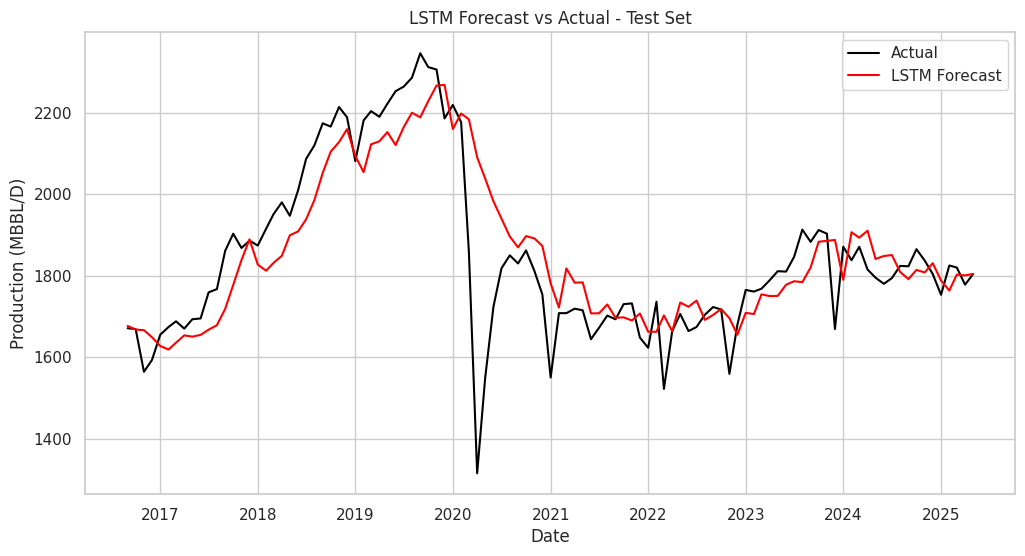

In [13]:
plt.figure(figsize=(12,6))
plt.plot(test_periods, y_test, label='Actual', color='black')
plt.plot(test_periods, y_pred, label='LSTM Forecast', color='red')
plt.title("LSTM Forecast vs Actual - Test Set")
plt.xlabel("Date")
plt.ylabel("Production (MBBL/D)")
plt.legend()
plt.show()

We trained an LSTM deep learning model using a multivariate feature set that included lagged values, rolling window statistics, and temporal indicators. The model architecture, including the number of units, dropout rate, batch size, and epochs, was optimized through Bayesian hyperparameter tuning with Optuna. All results were saved in a standardized format consistent with other models, facilitating unified comparison in the 6-model-comparison.ipynb noteboo